## Simulation based inference: Results for the 1000BD cohort

The last step of the VAB workflow employs Simulation Based Inference (SBI) for estimation of the full posterior values of the parameter $G$. Here, a deep neural estimator is trained to provide a relationship between the parameters of a model (black box simulator) and selected descriptive statistics of the observed data. 

The procedure is split into following steps:

1. Simulations using parameters drawn from the prior distributions
2. Training the deep neural estimator (sequential neural posterior estimation, SNPE)
3. Computing the posterior density with respect to the empirical observables.

The SBI algorithm might be very computationally demanding due to the first step. In order to provide all the necessary details to replicate SBI, we make the assumptions that all necessary simulations have been computed and stored in the `$MYPATH/aging_virtual_brain/data/interim`. 

The second step is less computationally demanding, but it could benefit from a parallel computing solutions. To show how to obtain G distribution without using any extra computational resources, we are going to report the SBI solutions of the VAB pipeline in two notebooks. In the current one, we show how to run the deep neural estimator to obtain $G$ for a subcohort.

The notebook `$MYPATH/aging_virtual_brain/notebooks/vab_github_SBI.ipynb` shows how to perform SBI step-by-step. The current notebook is meant to show the output of SBI for the entire cohort. We also repeat the explanation of SBI.

Before proceeding in any further explanation of the SBI employed in the VAB pipeline, we remind that the intermediate simulations are also personal data. Therefore, we invite the user to read the following code blocks.

## Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external` and the simulated dataset is located in the folder `$MYPATH/aging_virtual_brain/data/interim`. First, verify that the datasets are present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

## Import packages

Import the most useful packages for this notebook

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
from sklearn import linear_model

Upload TVB packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import utils
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from src import data,analysis,simulation
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
from multiprocessing import Pool
from functools import partial
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
#import ipywidgets as widgets
# Pay attention that it crashes with any other interactive package
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
LOG = get_logger('demo')
import scipy.stats
from scipy.stats import zscore
#import sklearn
#from sklearn.decomposition import FastICA
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from scipy import stats
import pandas as pd
import seaborn as sns

from pingouin import ancova
from pingouin import partial_corr

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


Import the SBI packages

In [4]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi,simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

import scipy

from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Define your target/results folder

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on numba: v{}'.format(numba.__version__))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))
print('Running on numpba: v{}'.format(numba.__version__))

Running on numpy: v1.20.3
Running on numba: v0.53.1
Running on torch: v1.8.1
Running on sbi: v0.16.0
Running on numpba: v0.53.1


In [6]:
separator  = ''
P_LIST     = ['sub-1209']
AGE_LIST   = [76.3]
mysubj_idx = 0
mysubj     = P_LIST[mysubj_idx]
magic_number = 124538.470647693 #SC COHORT MAX FOR JULICH DATASET
BOLD_TR      = 2200
print(len(P_LIST))

1


In [7]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
path_root   = os.path.dirname(os.getcwd())
separator = ''
jul         = data.Julich() 
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs        = jul.list_subjects()
SUBJ_TARG    = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
print(subj_ID[SUBJ_TARG])
print(subj_age[SUBJ_TARG])
_,weights     = jul.load_subject_sc_100(mysubj)
NHALF         = int(weights.shape[0]/2)

sub-1209
76.3


## Simulation-based inference

The global modulation parameter G of the brain network model can be also estimated by SBI tailored to Bayes rule in order to retrieve the model  parameter space compatible with the empirical data [Gonçalves et al., 2020](https://doi.org/10.7554/eLife.56261). Statistical inference consists of the automatic identification of possible parameters  via the likelihood function $p(X|\theta)$, which quantifies the probability that a given set $\theta$ generates the vector of raw data or low-dimensional data features $X$. The Bayesian estimation consists in $p(\theta|X) = p(X|\theta) p(\theta)$, where $p(\theta|X)$ is the posterior that quantifies the probabilistic consistency between the selected parameter space and fitted empirical data.

In the specific case of the VAB pipeline, we wanted to estimate the posterior distribution of $G$. Hence, 

$$p(G_{SBI}|X) = p(X|G_{SBI}) p(G_{SBI})$$

where $p(X|G_{SBI})$ is the likelihood function, which is obtained via SNPE with a flexible neural density estimation trained on low-dimensional data features. In short, SNPE traines a deep neural network on a certain budget of simulations (2000 in the VAB case) on set of low dimensional features ($X$).

The set of chosen low dimensional features are the homotopic FC ($<Homotopic_{FC}>$),FCD variance difference ($\sigma^2_{diff}$) and the standard deviation of interhemispheric FC stream.

$p(G_{SBI})$ is set as a uniform distribution of $G$ values (truncated between 1.5 and 3.2) containing as many samples as the chosen budge of simulation. See the following codeblock to generate a uniform distribution of 2000 Gs.

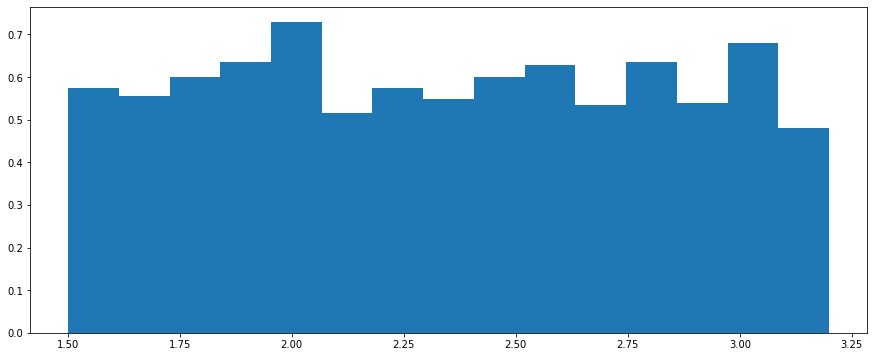

In [14]:
G_prior = np.random.uniform(1.5,3.2,2000)
count, bins, ignored = plt.hist(G_prior, 15, density=True)
plt.show()

Thanks to the uniform distribution, the final posterior is given by $p(G_{SBI}|X_{empirical}) = p(X_{simulated}|G_{SBI})$, which implies that the final estimation of the posterior is computed by the likelihood network via a feedfowrad feeding of the **empirical** summary statistics.

To estimate a posterior distribution for each individual, this procedure has to be repeated for each single subject, which require 2000 simulations, computation of the summary statistics for both the simulated and empirical data and the training of the deep neural network.  

Consequently, we decided to split the 2000 simulations task on HPC facilites, while this notebook will show how to train a deep neural network, feed it with the empirical summary statistics and obtain the posterior distribution.

In [8]:
Res_dir     = jul.data_root
path_root   = os.path.dirname(os.path.dirname(os.getcwd()))
cwd = os.getcwd()

List of all subjects

In [10]:
P_LIST    = ['sub-1021',
 'sub-0189',
 'sub-0173',
 'sub-0960',
 'sub-0394',
 'sub-1272',
 'sub-1215',
....
 'sub-1265',
 'sub-1278',
 'sub-1280',
 'sub-1303',
 'sub-1309',
 'sub-1313']

In [ ]:
FLAG_LIST = [....]

In [12]:
print(len(P_LIST))
print(len(FLAG_LIST))

649
649


In [13]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul    = data.Julich() 
# subjs  = jul.list_subjects()
parce_list = jul.parcellation_100()
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs      = jul.list_subjects()
SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
print(subj_ID[SUBJ_TARG])
print(subj_age[SUBJ_TARG])

sub-1209
76.3


In [14]:
def collect_gridsearch(G,noise,mysubj,alpha1,alpha2,flag_ds):
    
    separator       = ''
    
#     if flag_ds == 3:
        
#         str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_SIXTH_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
    
#     elif flag_ds == 2:
        
#         str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_FIFTH_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
    
#     elif flag_ds == 1:
        
#         str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_FOURTH_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
        
#     else:
#         str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
        
    if flag_ds == 3:
        
        str_save        = separator.join(['interim/virtual_cohort_heun_100_SBI_FOURTH/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
    
    elif flag_ds == 2:
        
        str_save        = separator.join(['interim/virtual_cohort_heun_100_SBI_THIRD/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
    
    elif flag_ds == 1:
        
        str_save        = separator.join(['interim/virtual_cohort_heun_100_SBI_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])
        
    else:
        str_save        = separator.join(['interim/virtual_cohort_heun_100_SBI_FIRST/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])

    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [15]:
def collect_demo(G,noise,mysubj,alpha1,alpha2,flag_ds):
    
    output_data     = collect_gridsearch(G,noise,mysubj,alpha1,alpha2,flag_ds)
    
    mysubj          = output_data['mysubj']
    myage           = output_data['myage']
    
    
    return mysubj,myage

In [16]:
def collect_FCD_OV_gs(G,noise,mysubj,alpha1,alpha2,flag_ds):
    
    output_data = collect_gridsearch(G,noise,mysubj,alpha1,alpha2,flag_ds)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

In [17]:
try_idx_g = 0
try_idx_n = 0
mysubj    = P_LIST[0]

A_TAU      = [0.0]
B_TAU      = [0.0]

ALPHA1     = A_TAU[0]
ALPHA2     = A_TAU[0]
print(mysubj)

sub-1021


## 1. Collection of the summary statistics from simulated and empirical data

All the simulations were performed on HPC facilities and collected in the folder `$MYPATH/aging_virtual_brain/data/interim`. SBI needs a set of summary statistics to train the neural network and estimate the posterior distribution of $G$. The code blocks below collect all the summary statistics for the selected prior distribution and the associated parameters maps for the selected group of subject of this notebooks. They also collect all the summary statistics for the respective gridsearch/parameter sweep-based selection of G in order to compare the two methods. To speed up the process, the last code-block upload a separate intermediate file to upload all the selected summary statistics and perform the deep neural network training.  

The following codeblocks collect all the parameter-sweep based Gs, which will be compared with SBI estimate.

In [18]:
str_save_feature     = separator.join(['interim/julich_100_VAB_SBI_G_sweep.npz'])

out_feature          = os.path.join(jul.data_root,str_save_feature)

summary_data         = np.load(out_feature)


P_LIST                    = summary_data["P_LIST"]
myage_list                = summary_data["myage_list"]
mysubj_list               = summary_data["mysubj_list"]

FCD_SUBJ_VAR_OV_GS        = summary_data["FCD_SUBJ_VAR_OV_GS"]

G_MAX                     = summary_data["G_MAX"]
N_MAX                     = summary_data["N_MAX"]

### 2. Upload Inference Results

Since we wanted just to show the final output of the SBI estimation, we collect all the estimated $G$s and we plot the final results in the following code blocks.

In [19]:
num_samples   = 1000
G_POST_MATRIX = np.zeros([num_samples,len(P_LIST)])
G_POST_MEAN   = np.zeros(len(P_LIST))

for subj_idx in range(len(P_LIST)):
    
    mysubj = P_LIST[subj_idx]
    
    str_save                  = separator.join(['interim/julich_coh_100_SBI/julich_sbi_G','_pat',f"{mysubj}",'.npz'])

    out_path                  = os.path.join(jul.data_root,str_save)
    
    output_sbi                = np.load(out_path)
    
    G_POST_MATRIX[:,subj_idx] = output_sbi["G_posterior"]
    G_POST_MEAN[subj_idx]     = output_sbi["G_mean"]
    
    

    

## 3. The trend with age of the estimated G and the comparison with parameter sweep estimate.

The following code blocks shows the trend of $G_{SBI}$ with age, the comparison with the paramter sweep and the posterior distributions for the youngest and the oldest section of the 1000BRAINS cohort.

In [ ]:
d              = os.path.join(jul.ds_external)
separator      = ''
score_frame    = pd.read_csv(separator.join([d,'/1000BD_cognitivescore_1visit.csv']),delimiter=";",decimal = ',')
score_frame.columns

In [24]:
subj_age_CS       = score_frame["Age"]
gender_CS         = score_frame["Sex"].tolist()
subj_ID_CS        = score_frame["ID"].tolist()
visit_CS          = score_frame["Visit"].tolist()
education_CS      = score_frame["ISCED_97"]

gender_list_cs    = [int(gender_loc=='Female') for gender_loc in gender_CS]

In [25]:
# loc_plist_cs  = [loc_subj for loc_subj in range(len(subj_ID_CS)) if np.sum(subj_ID_CS[loc_subj]==np.array(P_LIST))]
loc_plist_cs =[]
for pidx in range(len(P_LIST)):
    loc_plist_cs_entry = [loc_subj for loc_subj in range(len(subj_ID_CS)) if P_LIST[pidx] in subj_ID_CS[loc_subj]][0]
    loc_plist_cs +=[loc_plist_cs_entry]

0.25385782880181507
5.861037231349134e-11
1.3631300147240393e-11
r(%) =26.1


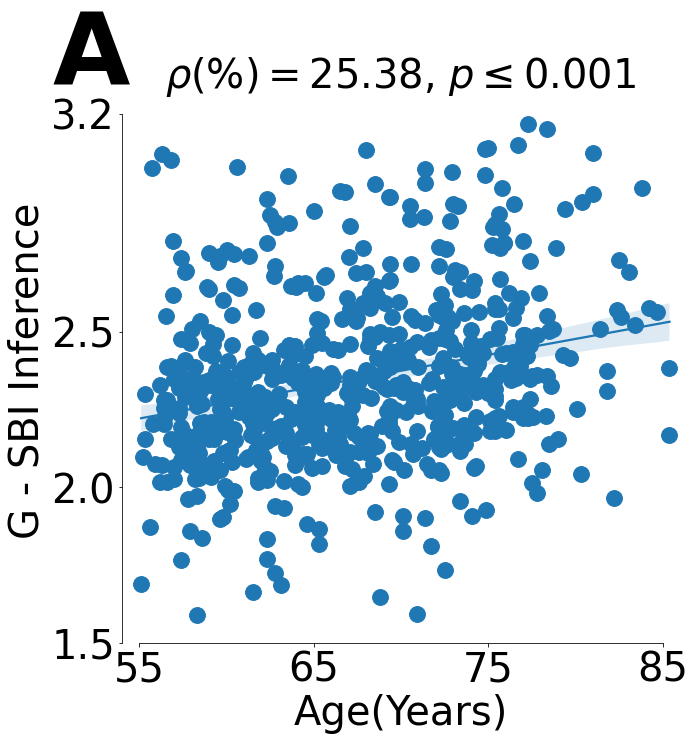

In [27]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd())
f,ax = plt.subplots(figsize=(10,10))

font_size = 40

p_idx = 0

feat_list = ['G - SBI Inference']

mymat    = np.mean(G_POST_MATRIX,axis=0)

cc_sc    = mymat
age_cc   = myage_list

mygender_cs  = np.array(gender_list_cs)[loc_plist_cs]
myedu_cs     = np.array(education_CS[loc_plist_cs])

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]



slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
# ax.plot(age_cc, cc_hat,linewidth=4)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =25.38$, $p \leq 0.001$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.text(50, 3.3,r'$\mathbf{A}$', fontsize=font_size+60)


ax.set_xticks([55,65,75,85])
ax.set_yticks([1.5,2.0,2.5,3.2])
sns.despine(trim=True)


gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)

print(p_value)
print(f'r(%) ={r_value.round(1)}')


4.449322446876078e-28
r(%) =41.3


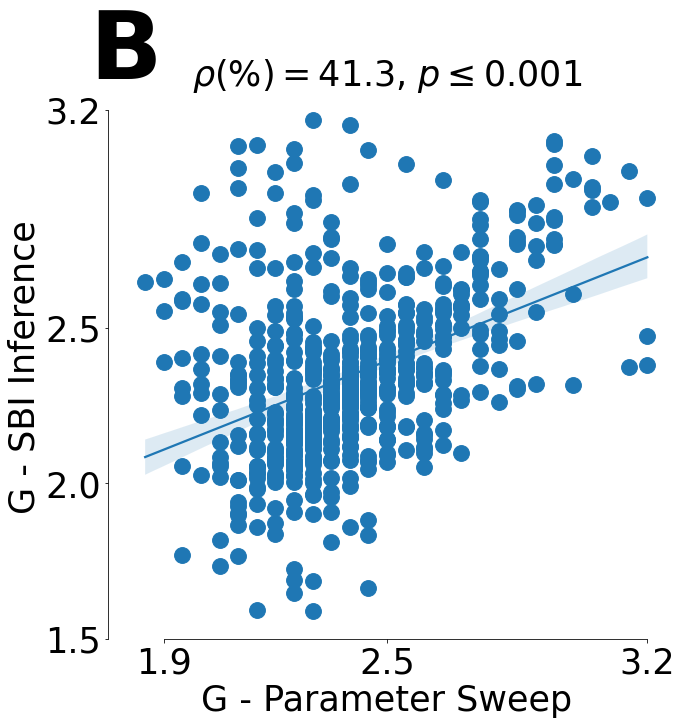

In [28]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd())

f,ax = plt.subplots(figsize=(10,10))

font_size = 35

p_idx = 0

feat_list = ['G - SBI Inference']

mymat    = np.mean(G_POST_MATRIX,axis=0)

cc_sc    = mymat
age_cc   = G_MAX

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]



slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =41.3$, $p \leq 0.001$',fontsize=font_size);
ax.set_xlabel("G - Parameter Sweep",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
# ax.set_xlim([54,86])
ax.set_xlim([1.75,3.25])
plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.text(1.7, 3.3,r'$\mathbf{B}$', fontsize=font_size+60)

ax.set_yticks([1.5,2.0,2.5,3.2])
ax.set_xticks([1.9,2.5,3.2])
sns.despine(trim=True)

print(p_value)
print(f'r(%) ={r_value.round(1)}')


In [29]:
G_POST_OLD = G_POST_MATRIX[:,np.array(myage_list)>80]
myage_old  = np.array(myage_list)[np.array(myage_list)>80]

G_POST_young = G_POST_MATRIX[:,np.bitwise_and(np.array(myage_list)<57.3,np.array(myage_list)>55)]
myage_young    = np.array(myage_list)[np.bitwise_and(np.array(myage_list)<57.3,np.array(myage_list)>55)]

In [31]:
import pandas as pd
import seaborn as sns
age_rep        = np.repeat(np.array(myage_list),G_POST_MATRIX.shape[0])
G_POST_RESHAPE = np.ravel(G_POST_MATRIX.T)
df_SC    = pd.DataFrame(
            {'age':age_rep ,'gcoup':G_POST_RESHAPE})

In [32]:
import pandas as pd
import seaborn as sns
age_rep        = np.repeat(np.array(myage_young),G_POST_young.shape[0])
G_POST_RESHAPE = np.ravel(G_POST_young.T)
df_SC    = pd.DataFrame(
            {'age':age_rep ,'gcoup':G_POST_RESHAPE})

Text(-1.0, 3.35, '$\\mathbf{C}$')

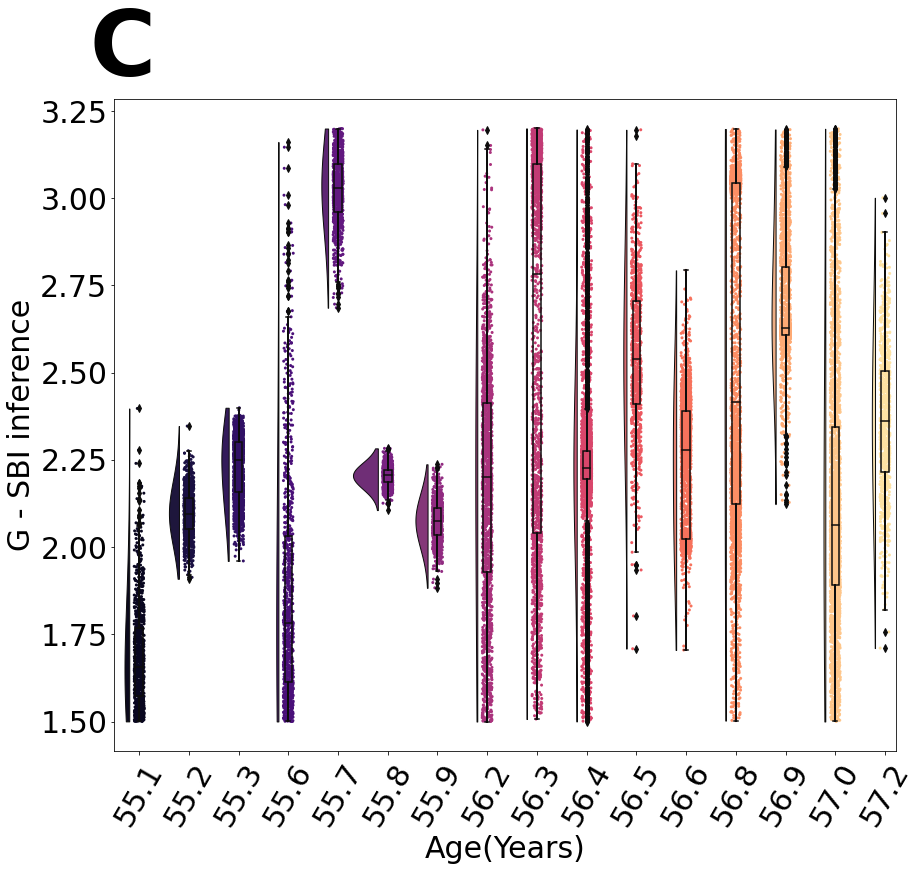

In [33]:
import ptitprince as pt
from scipy import stats
from statannot import add_stat_annotation

separator = ''
# ordered = ['SNC','NC', 'MCI', 'AD']
font_size = 30
# periatel_ins_cung
dx="age"; dy="gcoup"; ort="v"; pal = "magma"; sigma = 1.0
f, ax = plt.subplots(figsize=(14, 12))
ax=pt.RainCloud(x = dx, y = dy, data = df_SC , palette = pal, bw = sigma,
                 width_viol = 1.0, ax = ax, orient = ort)

plt.tick_params(axis='x', labelsize=font_size,rotation = 60)
plt.tick_params(axis='y', labelsize=font_size)

# sns.boxplot(age_rep,G_POST_RESHAPE)
ax.set_ylabel("G - SBI inference",fontsize=font_size)
ax.set_xlabel("Age(Years)",fontsize=font_size)
# test_results = add_stat_annotation(ax, data=df_within, x=dx, y=dy, order=ordered,
#                                    box_pairs=[('NC','MCI'), ("MCI", "AD"), ("NC", "AD"),('SNC','MCI'), ("SNC", "AD"),],
#                                    test='Mann-Whitney-ls', text_format='simple', 
#                                    loc='inside', verbose=2)
ax.grid(False)
str_feature = "G - SBI Inference" #Limbic Mask FC stream std
str_title  = separator.join([str_feature]) #' p_val = ',str(round(p,7))
ax.text(-1.0, 3.35,r'$\mathbf{C}$', fontsize=font_size+60)

In [34]:
import pandas as pd
import seaborn as sns
age_rep        = np.repeat(myage_old,G_POST_OLD.shape[0])
G_POST_RESHAPE = np.ravel(G_POST_OLD.T)
df_SC    = pd.DataFrame(
            {'age':age_rep ,'gcoup':G_POST_RESHAPE})

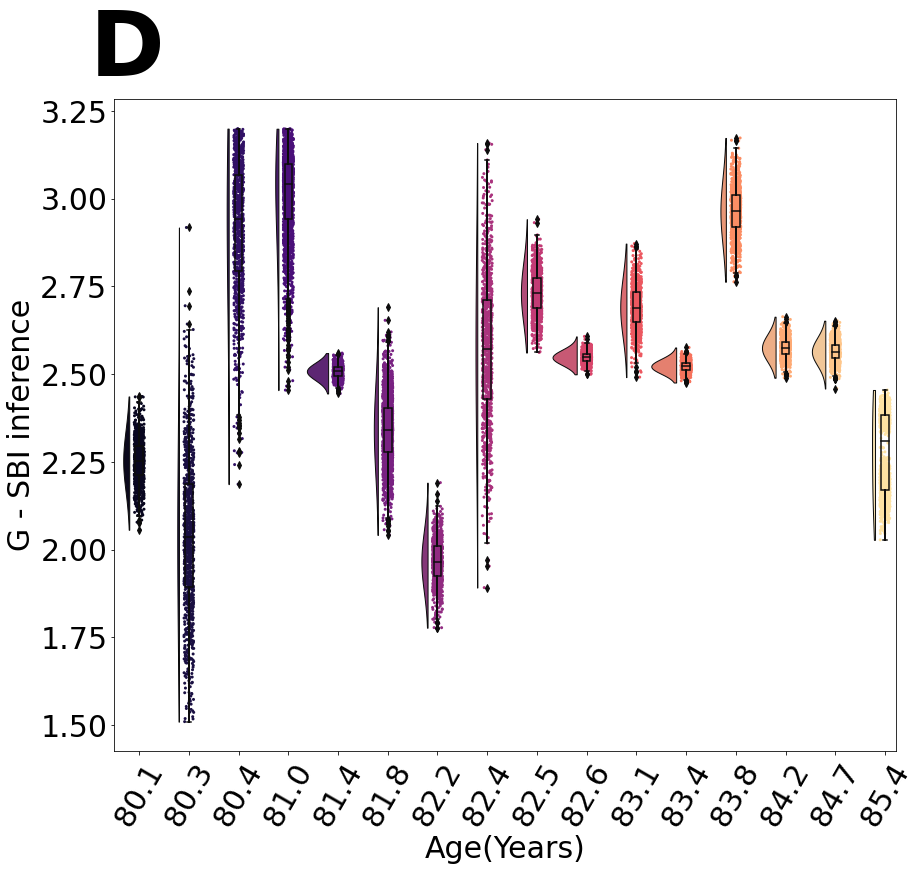

In [35]:
import ptitprince as pt
from scipy import stats
from statannot import add_stat_annotation

separator = ''
font_size = 30
dx="age"; dy="gcoup"; ort="v"; pal = "magma"; sigma = 1.0
f, ax = plt.subplots(figsize=(14, 12))
ax=pt.RainCloud(x = dx, y = dy, data = df_SC , palette = pal, bw = sigma,
                 width_viol = 1.0, ax = ax, orient = ort)

plt.tick_params(axis='x', labelsize=font_size,rotation = 60)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_ylabel("G - SBI inference",fontsize=font_size)
ax.set_xlabel("Age(Years)",fontsize=font_size)

ax.grid(False)
str_feature = "G - SBI Inference" #Limbic Mask FC stream std
str_title  = separator.join([str_feature]) #' p_val = ',str(round(p,7))
ax.text(-1.0, 3.35,r'$\mathbf{D}$', fontsize=font_size+60)

f.set_rasterized(True)
